In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [352]:
# collection of functions not organized into classes
def PrettyPrintBinary(state):
    outstr = ""
    if (type(state) == list and type(state[0]) == tuple):
        for i in range(len(state)):
            # if (not np.isclose(state[i][0] * np.conj(state[i][0]), 0.00000, rtol=1e-5)):
            outstr += f"{state[i][0]:.4f} |{state[i][1]}>"
            # outstr += (str)(state[i][0])
            # outstr += " |"
            # outstr += state[i][1]
            # outstr += "> "
            if (i < len(state) - 1):
                outstr += " + "
        print(outstr)
    else:
        print("State is not valid")
def PrettyPrintInteger(state):
    if (type(state) == list):
        if(type(state[0]) == tuple):
            state = DiracToVec(state)
        outstr = ""
        for i in range(len(state)):
            if (state[i] != 0):
                if (i != 0):
                    outstr += "+ "
                outstr += (str)(state[i])
                outstr += " |"
                outstr += str(i)
                outstr += "> "
        print(outstr)
    else:
        print("State passed to PrettyPrintInteger is not valid")

def VecToDirac(myVec):
    if ((type(myVec) == list and len(myVec) % 2 == 0)):
        newState = []
        binlen = int(np.log2(len(myVec)))
        for i in range(len(myVec)):
            if (myVec[i] != 0):
                bi = bin(i)[2:].zfill(binlen)
                newState.append((myVec[i], bi))
        return newState
    else:
        print("Error in VecToDirac")
        
def DiracToVec(state):
    if (not (type(state) == list and type(state[0]) == tuple)):
        print("Error in DiracToVec")
    else:
        newVec = []
        for i in range(2**len(state[0][1])):
            newVec.append(0)
        for s in state:
            newVec[int(s[1], 2)] = s[0]
        return newVec
def ReadInputString(myInput_lines):
    myInput=[]
    myInput_lines=myInput_lines.split('\n')
    myInput_lines = [ i for i in myInput_lines if i!='']
    numberOfWires=int(myInput_lines[0])
    for line in myInput_lines[1:]:
        myInput.append(line.split())
    return (numberOfWires,myInput)

def GetStateFromFile(file, dirac):
    a = open(file).read()
    a = a.split("\n")
    output = []
    for i in a:
        x = i.split(' ')
        output.append(float(x[0]) + float(x[1]) * 1.j)
    if (dirac):
        return VecToDirac(output)
    return output
    
def TensorMe(listOfMatrices):
    current = listOfMatrices[0]
    for i in range(len(listOfMatrices) - 1):
        current = np.kron(listOfMatrices[i+1], current)
    return current
    

In [392]:
# Simulator S
class S:
    def H(wire, inputState):
        newState = []
        for s in inputState:
            if (s[1][wire] == '0'):
                bi = list(s[1])
                bi[wire] = '0'
                newState.append((s[0] * np.sqrt(1/2), "".join(bi)))
                bi[wire] = '1'
                newState.append((s[0] * np.sqrt(1/2), "".join(bi)))
            if (s[1][wire] == '1'):
                bi = list(s[1])
                bi[wire] = '0'
                newState.append((s[0] * np.sqrt(1/2), "".join(bi)))
                bi[wire] = '1'
                newState.append((s[0] * -np.sqrt(1/2), "".join(bi)))
        return newState

    def Phase(wire, theta, inputState):
        newState = []
        for s in inputState:
            if (s[1][wire] == '0'):
                newState.append(s)
            else:
                newState.append((s[0] * np.exp(1.j * theta), s[1]))
        return newState

    def CNOT(controlwire, notwire, inputState):
        newState = []
        for s in inputState:
            if (s[1][controlwire] == '0'):
                newState.append(s)
            else:
                bi = list(s[1])
                bi[notwire] = str((int(bi[notwire]) + 1) % 2)
                # if (bi[notwire] == '0'):
                #     print("here")
                #     bi[notwire] == '1'
                # else:
                #     bi[notwire] == '0'
                string = "".join(bi)                
                newState.append((s[0], string))
        return newState
    
    def AddDuplicates(inputState):
        bidict = {}
        for s in inputState:
            if (s[1] in bidict):
                bidict[s[1]] += s[0]
            else:
                bidict[s[1]] = s[0]
        
        outstate = []
        for i in bidict.keys():
            if (not np.isclose(bidict[i], 0)):
                outstate.append((bidict[i], i))
        outstate = sorted(outstate, key=lambda x: int(x[1], 2))
        return outstate
    
    def measure(state, size = 1):
        possibleStates = []
        probabilities = []
        for s in state:
            possibleStates.append(s[1])
            probabilities.append(s[0] * np.conjugate(s[0]))
        rng = np.random.default_rng(seed=123)
        return rng.choice(possibleStates, size=size, p=np.real(probabilities))

    def ReadAndProcessString(input_lines, test=False, measures=1, ignoreMeasure=False):
        numberOfWires, inputGates = ReadInputString(input_lines)
        bin = ''
        for i in range(numberOfWires):
            bin += '0'
        currentState = [(1, bin)]
        for g in inputGates:
            
            if (g[0] == 'INITSTATE'):
                if (g[1] == 'BASIS'):
                    currentState[0] = (1, g[2][1:-1])
                    if(test):
                        print("BASIS")
                if (g[1] == 'FILE'):
                    currentState = GetStateFromFile(g[2], True)
            if (g[0] == 'H'):
                if (test):
                    print("H " + g[1])
                currentState = S.H(int(g[1]), currentState)
            if (g[0] == 'P'):
                if (test):
                    print("P " + g[2])
                currentState = S.Phase(int(g[1]), float(g[2]), currentState)
            if (g[0] == 'CNOT'):
                if (test):
                    print("CNOT " + g[1] + " " + g[2])
                currentState = S.CNOT(int(g[1]), int(g[2]), currentState)
            currentState = S.AddDuplicates(currentState)
            if (test):
                PrettyPrintBinary(currentState)
            if (g[0] == 'MEASURE' and not ignoreMeasure):
                return S.measure(currentState, measures)
        return currentState

In [393]:
# Class for simulator M-a
class MA:
    H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
    
    def Hadamard(i, k):
        """creates a hadamard array
        i: target wire
        k: number of wires"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(MA.H)
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr)
    def Phase(i, k, theta):
        """creates a phase matrix
        i: target wire
        k: number of wires
        theta: the phase to rotate by"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(np.array([[1, 0], [0, np.exp(1.j * theta)]]))
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr)
    def CNOT(controlwire, otherwire, totalwires):
        """creates a matrix for a CNOT gate
        controlwire: the control wire
        otherwire: the target wire (must be adjacent to control)
        totalwires: yeah"""
        if not((controlwire - 1 == otherwire) or (controlwire + 1 == otherwire)):
            raise(ValueError("Controlwire and otherwire must be adjacent"))
        arr = []
        hasntRun = True
        j = 0
        while j < totalwires:
            if (j == controlwire or j == otherwire) and hasntRun:
                t = np.eye(4)
                if (controlwire < otherwire):
                    t[:, [2, 3]] = t[:, [3, 2]] 
                else:
                    t[1, 1] = 0
                    t[3, 3] = 0
                    t[3, 1] = 1
                    t[1, 3] = 1
                    # t[:, [0, 1]] = t[:, [1, 0]]
                arr.append(t)
                j = j + 1
                hasntRun = False
            elif j < controlwire:
                arr.append(np.eye(2))
            elif j > otherwire:
                arr.append(np.eye(2))
            j = j + 1
        return TensorMe(arr)
    
    def CreateCircutMatrix(input_lines):
        numberOfWires, inputGates = ReadInputString(input_lines)
        currentState = list(np.zeros(numberOfWires))
        ListOmatrices = []
        for g in inputGates:
            if (g[0] == 'H'):
                ListOmatrices.append(MA.Hadamard(int(g[1]), numberOfWires))
            if (g[0] == 'P'):
                ListOmatrices.append(MA.Phase(int(g[1]), numberOfWires, float(g[2])))
            if (g[0] == 'CNOT'):
                ListOmatrices.append(MA.CNOT(int(g[1]), int(g[2]), numberOfWires))
            
        TheMatrix = np.eye(2**numberOfWires)
        ListOmatrices = ListOmatrices[::-1]
        for m in ListOmatrices:
            TheMatrix = TheMatrix @ m
        return TheMatrix
        
            

In [394]:
# Class for simulator M-b
class MB:
    H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
    
    def Hadamard(i, k, state):
        """creates a hadamard array
        i: target wire
        k: number of wires"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(MA.H)
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr) @ state
    def Phase(i, k, theta, state):
        """creates a phase matrix
        i: target wire
        k: number of wires
        theta: the phase to rotate by"""
        arr = []
        for j in range(k):
            if j < i:
                arr.append(np.eye(2))
            if j == i:
                arr.append(np.array([[1, 0], [0, np.exp(1.j * theta)]]))
            if j > i:
                arr.append(np.eye(2))
        return TensorMe(arr) @ state
    def CNOT(controlwire, otherwire, totalwires, state):
        """creates a matrix for a CNOT gate
        controlwire: the control wire
        otherwire: the target wire (must be adjacent to control)
        totalwires: yeah"""
        if not((controlwire - 1 == otherwire) or (controlwire + 1 == otherwire)):
            raise(ValueError("Controlwire and otherwire must be adjacent"))
        arr = []
        hasntRun = True
        j = 0
        while j < totalwires:
            if (j == controlwire or j == otherwire) and hasntRun:
                t = np.eye(4)
                if (controlwire < otherwire):
                    t[:, [2, 3]] = t[:, [3, 2]] 
                else:
                    t[1, 1] = 0
                    t[3, 3] = 0
                    t[3, 1] = 1
                    t[1, 3] = 1
                    # t[:, [0, 1]] = t[:, [1, 0]]
                arr.append(t)
                j = j + 1
                hasntRun = False
            elif j < controlwire:
                arr.append(np.eye(2))
            elif j > otherwire:
                arr.append(np.eye(2))
            j = j + 1
        return TensorMe(arr) @ state
    
    def ReadAndRunCircuit(input_lines, startstate, test=False):
        numberOfWires, inputGates = ReadInputString(input_lines)
        currentState = startstate
        ListOmatrices = []
        for g in inputGates:
            if (g[0] == 'H'):
                currentState = MB.Hadamard(int(g[1]), numberOfWires, currentState)
            if (g[0] == 'P'):
                currentState = MB.Phase(int(g[1]), numberOfWires, float(g[2]), currentState)
            if (g[0] == 'CNOT'):
                currentState = MB.CNOT(int(g[1]), int(g[2]), numberOfWires, currentState)
            if (g[0] == 'MEASURE'):
                return S.measure(VecToDirac(list(currentState)))
            if (test):
                print(currentState)
        return currentState

In [395]:
# turn each nonatomic gate into a string of atomic gates
def NOT(wire):
    return f"H {wire}\nP {wire} {np.pi}\nH {wire}\n"
def Rz(wire, phase):
    return f"{NOT(wire)}P {wire} {-phase/2}\n{NOT(wire)}P {wire} {phase/2}\n"
def CRz(controlwire, targetwire, phase):
    return f"CNOT {controlwire} {targetwire}\nP {targetwire} {phase/2}\nCNOT {controlwire} {targetwire}\nP {targetwire} {-phase/2}\n"
def CPhase(controlwire, targetwire, phase):
    return f"P {targetwire} {phase/2}\nCNOT {controlwire} {targetwire}\nP {targetwire} {-phase/2}\nCNOT {controlwire} {targetwire}\nP {controlwire} {phase/2}\n"
def Swap(firstwire, secondwire):
    return f"CNOT {firstwire} {secondwire}\nCNOT {secondwire} {firstwire}\nCNOT {firstwire} {secondwire}\n"
def Reverse(firstwire, lastwire):
    out = ""
    for i in range(firstwire, firstwire + int((lastwire-firstwire)/2)):
        out += f"{Swap(i, lastwire-i-1)}\n"
    return out

In [396]:
# Precompiler code
def is_number(s): # stolen from stackoverflow: https://stackoverflow.com/questions/354038/how-do-i-check-if-a-string-represents-a-number-float-or-int
    try:
        float(s)
        return True
    except ValueError:
        return False

def Precompile(input):
    input = input.split("\n")
    output = """"""
    for i in input:
        a = i.split(' ')
        if (a[0] == "H" or a[0] == "CNOT" or a[0] == "P" or is_number(a[0]) or a[0] == "MEASURE" or a[0] == "INITSTATE"):
            output += i
            output += "\n"
        if (a[0] == "NOT"):
            output += NOT(int(a[1]))
        if (a[0] == "RZ"):
            output += Rz(int(a[1]), float(a[2]))
        if (a[0] == "CRZ"):
            output += CRz(int(a[1]), int(a[2]), float(a[3]))
        if (a[0] == "CPHASE"):
            output += CPhase(int(a[1]), int(a[2]), float(a[3]))
        if (a[0] == "SWAP"):
            output += Swap(a[1], a[2])
        if (a[0] == "REVERSE"):
            output += Reverse(int(a[1]), int(a[2]))
    return output
        

In [397]:
#early tests
myState=[
  (-np.sqrt(0.125), '11' ),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01') ,
  (-np.sqrt(0.125), '11' )
]
myState2=[
   (np.sqrt(0.1)*1.j, '101'),
   (np.sqrt(0.5), '000') ,
   (-np.sqrt(0.4), '010' )]
myEquivilentState2 = [np.sqrt(0.5), 0, -np.sqrt(0.4), 0, 0, np.sqrt(0.1)*1.j, 0, 0]
PrettyPrintBinary(myState2)
PrettyPrintInteger(myState2)
# PrettyPrintBinary(VecToDirac(myEquivilentState2))
PrettyPrintInteger(DiracToVec(myState2))
PrettyPrintBinary(VecToDirac(DiracToVec(myState2)))

0.0000+0.3162j |101> + 0.7071 |000> + -0.6325 |010>
0.7071067811865476 |0> + -0.6324555320336759 |2> + 0.31622776601683794j |5> 
0.7071067811865476 |0> + -0.6324555320336759 |2> + 0.31622776601683794j |5> 
0.7071 |000> + -0.6325 |010> + 0.0000+0.3162j |101>


In [398]:
# second set of early tests
sampleInput = '''
3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
'''
sampleInput2 = open('example.circuit').read()
input3 = open('rand.circuit').read()
# numberOfWires,myInput=ReadInputString(sampleInput)
# PrettyPrintBinary(S.ReadAndProcessString(sampleInput))
# PrettyPrintBinary(S.ReadAndProcessString(sampleInput2))
input3State = np.zeros(32)
input3State[0] = 1
PrettyPrintBinary(S.ReadAndProcessString(input3))
PrettyPrintBinary(VecToDirac(list(MA.CreateCircutMatrix(input3) @ input3State)))

0.1457+0.1135j |00000> + 0.0431-0.1218j |00001> + -0.0002+0.0801j |00010> + 0.0504-0.0073j |00011> + 0.0723-0.0226j |00100> + -0.0344-0.0422j |00101> + 0.0539+0.0090j |00110> + 0.0018-0.0268j |00111> + 0.1346-0.1256j |01000> + -0.1041-0.0676j |01001> + 0.0107+0.0709j |01010> + 0.0315-0.0354j |01011> + 0.0079+0.2979j |01100> + 0.1961-0.0584j |01101> + -0.1131-0.0228j |01110> + 0.0257+0.0756j |01111> + 0.0015-0.0365j |10000> + -0.0127+0.0055j |10001> + -0.0821+0.0155j |10010> + 0.0160+0.0226j |10011> + -0.1717+0.3669j |10100> + 0.2775+0.0423j |10101> + -0.1469-0.0436j |10110> + 0.0074+0.1079j |10111> + -0.4427-0.0892j |11000> + 0.0343+0.3180j |11001> + -0.0548-0.2147j |11010> + -0.1210+0.0654j |11011> + -0.1814-0.0780j |11100> + -0.0059+0.1270j |11101> + -0.0578+0.0101j |11110> + -0.0118+0.0200j |11111>
-0.0141+0.1236j |00000> + 0.1055+0.1511j |00001> + -0.0532+0.2120j |00010> + -0.0337+0.0831j |00011> + -0.0979+0.0081j |00100> + -0.1009+0.1048j |00101> + 0.0332-0.1661j |00110> + 0.0229-

In [399]:
# more basic testing
testState1 = list(np.zeros((16)))
testState1[12] = 1.0
ar = MA.CNOT(0, 1, 4)
PrettyPrintBinary(VecToDirac(testState1))
PrettyPrintBinary(VecToDirac(list(testState1@ar)))

1.0000 |1100>
1.0000 |1100>


In [400]:
# testing strings
testCircuit = '''3
H 1
CNOT 1 2
P 0 0.45'''
# print(MA.CreateCircutMatrix(testCircuit))
startstate = [0, 0, 0, 0, 1, 0, 0, 0]
PrettyPrintBinary(VecToDirac(startstate))
c = MA.CreateCircutMatrix(testCircuit)
d = MB.ReadAndRunCircuit(testCircuit, startstate)
PrettyPrintBinary(VecToDirac(list(d)))
print(S.measure(VecToDirac(list(d))))

1.0000 |100>
0.7071+0.0000j |100> + 0.7071+0.0000j |110>
['110']


In [388]:
# Bunch of experimentation with Alex
PrettyPrintBinary(S.ReadAndProcessString(open("input.circuit").read()))
z = list(np.zeros(16))
z = [1/(np.sqrt(16)) for x in z]
# PrettyPrintBinary(VecToDirac(z))
# d = MB.ReadAndRunCircuit(open("example.circuit").read(), z)
# print(d)
# # print(VecToDirac(list(d)))
# PrettyPrintBinary(VecToDirac(list(d)))
# PrettyPrintBinary(VecToDirac(z))
compareCircuit = '''
4
INITSTATE BASIS |0100>
CNOT 1 0'''

PrettyPrintBinary(S.ReadAndProcessString(compareCircuit))
a = MA.CreateCircutMatrix(compareCircuit)
print(a)
b = np.zeros(16)
b[0] = 1

# print(b)
# PrettyPrintBinary(VecToDirac(list(MB.ReadAndRunCircuit(compareCircuit, list(b)))))
c = np.zeros((2,2))
c[0, 1] = 1
c[1, 0] = 1
# print(np.kron(np.eye(2), np.kron(c, np.kron(np.eye(2), np.eye(2)))))
PrettyPrintBinary(VecToDirac(list(a@b)))
# print(a @ b)

0.1541-0.0390j |00000> + 0.0490-0.0300j |00001> + -0.0213+0.0877j |00010> + -0.1116-0.2333j |00011> + -0.0339-0.0097j |00100> + -0.0167-0.1303j |00101> + -0.1959+0.0099j |00110> + -0.0980+0.0135j |00111> + -0.1808+0.0144j |01000> + 0.0538-0.0686j |01001> + 0.0010-0.0035j |01010> + -0.0215+0.0174j |01011> + -0.0072+0.1596j |01100> + -0.2231+0.0746j |01101> + -0.0379+0.0059j |01110> + 0.0739-0.0507j |01111> + -0.1480+0.0875j |10000> + -0.0633+0.2566j |10001> + 0.1169+0.0138j |10010> + -0.0267-0.0041j |10011> + 0.2192-0.2130j |10100> + -0.0489-0.1164j |10101> + -0.1479-0.1048j |10110> + 0.2232+0.0508j |10111> + -0.1396-0.2372j |11000> + 0.1848-0.0051j |11001> + -0.2632-0.0656j |11010> + 0.1752-0.0201j |11011> + 0.1122+0.0012j |11100> + 0.0242-0.1245j |11101> + -0.2083+0.0770j |11110> + 0.0548+0.3061j |11111>
1.0000 |1100>
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.

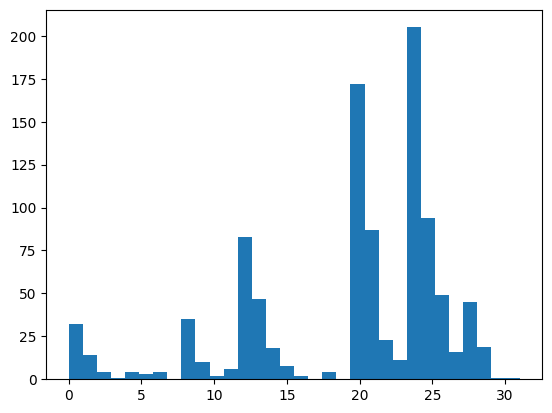

In [401]:
# Running simulator S 1000 times on measure.circuit
# x axis is in decimal notation
measureInput = open('measure.circuit').read()
count = []
for i in range(32):
    count.append(0)
temp = S.ReadAndProcessString(measureInput, measures=1000)

measured = [int(x, 2) for x in temp]
# for i in range(1000):
#     # count[int(S.ReadAndProcessString(measureInput), 2)] += 1
#     measured.append(int(S.ReadAndProcessString(measureInput), 2))
#     # print(int(S.ReadAndProcessString(measureInput), 2))
_ = plt.hist(measured, bins=32)

In [402]:
# testing advanced circuit descriptions
inputTest = open('input.circuit').read()
PrettyPrintBinary(S.ReadAndProcessString(inputTest))

secondInputTest = '''
3
INITSTATE BASIS |001>
H 2'''

# PrettyPrintBinary(S.ReadAndProcessString(secondInputTest))

0.1541-0.0390j |00000> + 0.0490-0.0300j |00001> + -0.0213+0.0877j |00010> + -0.1116-0.2333j |00011> + -0.0339-0.0097j |00100> + -0.0167-0.1303j |00101> + -0.1959+0.0099j |00110> + -0.0980+0.0135j |00111> + -0.1808+0.0144j |01000> + 0.0538-0.0686j |01001> + 0.0010-0.0035j |01010> + -0.0215+0.0174j |01011> + -0.0072+0.1596j |01100> + -0.2231+0.0746j |01101> + -0.0379+0.0059j |01110> + 0.0739-0.0507j |01111> + -0.1480+0.0875j |10000> + -0.0633+0.2566j |10001> + 0.1169+0.0138j |10010> + -0.0267-0.0041j |10011> + 0.2192-0.2130j |10100> + -0.0489-0.1164j |10101> + -0.1479-0.1048j |10110> + 0.2232+0.0508j |10111> + -0.1396-0.2372j |11000> + 0.1848-0.0051j |11001> + -0.2632-0.0656j |11010> + 0.1752-0.0201j |11011> + 0.1122+0.0012j |11100> + 0.0242-0.1245j |11101> + -0.2083+0.0770j |11110> + 0.0548+0.3061j |11111>


In [403]:
# implementation of NOT gate
NOTGate = '''
1
INITSTATE BASIS |1>
H 0
P 0 3.14159265
H 0'''
PrettyPrintBinary(S.ReadAndProcessString(NOTGate))

1.0000-0.0000j |0>


In [296]:
# Implementation of Rz(0.8)
RzGate = '''
1
INITSTATE BASIS |0>
H 0
P 0 3.14159265
H 0
P 0 -0.4
H 0
P 0 3.14159265
H 0
P 0 0.4'''
PrettyPrintBinary(S.ReadAndProcessString(RzGate))

0.9211-0.3894j |0>


In [297]:
# CRz gate with 0th wire as control and 1th wire as target
CRzGate = '''
2
INITSTATE BASIS |11>
CNOT 0 1
P 1 -0.4
CNOT 0 1
P 1 0.4'''
PrettyPrintBinary(S.ReadAndProcessString(CRzGate))

0.9211+0.3894j |11>


In [407]:
# working Controlled phase gate that rotates by 0.8
CPGate = '''
2
INITSTATE BASIS |00>
P 1 0.4
CNOT 0 1
P 1 -0.4
CNOT 0 1
P 0 0.4
'''
PrettyPrintBinary(S.ReadAndProcessString(CPGate))

1.0000 |00>


In [299]:
# Swap gate
SwapGate = '''
3
INITSTATE BASIS |010>
CNOT 0 2
CNOT 2 0
CNOT 0 2
'''
PrettyPrintBinary(S.ReadAndProcessString(SwapGate))

1.0000 |010>


In [410]:
# Testing the precompile step
testPrecompile = '''
9
INITSTATE BASIS |000000000>
H 0
CPHASE 0 5 0.3
P 1 0.3
CNOT 4 7
SWAP 2 8'''
print(Precompile(testPrecompile))
PrettyPrintBinary(S.ReadAndProcessString(testPrecompile))

9
INITSTATE BASIS |000000000>
H 0
P 5 0.15
CNOT 0 5
P 5 -0.15
CNOT 0 5
P 0 0.15
P 1 0.3
CNOT 4 7
CNOT 2 8
CNOT 8 2
CNOT 2 8

0.7071 |000000000> + 0.7071 |100000000>


In [301]:
firstPhaseEstimation = '''
2
INITSTATE BASIS |01>
H 0
CPHASE 0 1 0.4
H 0'''
PrettyPrintBinary(S.ReadAndProcessString(Precompile(firstPhaseEstimation)))

0.9605+0.1947j |01> + 0.0395-0.1947j |11>


['01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '11', '11', '11', '01', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '11', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01', '01']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0'

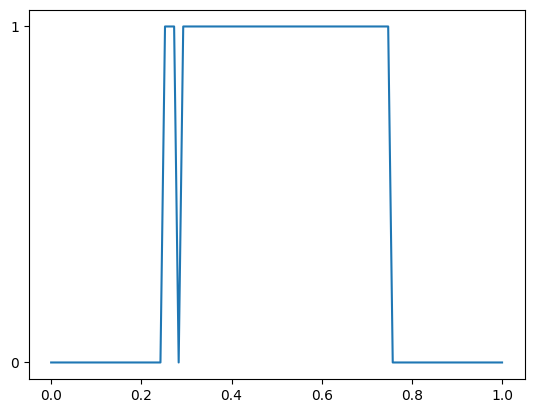

In [302]:
phiMeasures = []
for i in range(100):
    variedPhaseEstimation = '''
2
INITSTATE BASIS |01>
H 0
CPHASE 0 1 '''
    variedPhaseEstimation += str(np.pi * 2 * i / 100)
    variedPhaseEstimation += "\nH 0\nMEASURE"
    measures = S.ReadAndProcessString(Precompile(variedPhaseEstimation), measures=100)
    phiMeasures.append(max(set(measures), key = list(measures).count))
print(phiMeasures)
y = [m[0] for m in phiMeasures]
print(y)
x = np.linspace(0, 1, num = 100)
plt.plot(x, y)

Text(0.5, 1.0, '1000 measurements of phi = 0.143239')

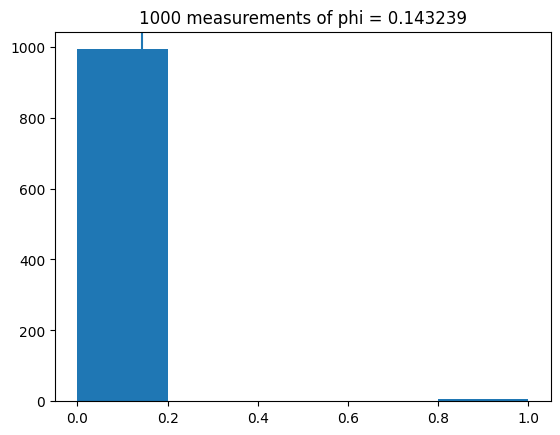

In [303]:
specificPhaseEstimation = '''
2
INITSTATE BASIS |01>
H 0
CPHASE 0 1 0.1432394487827058
H 0
MEASURE'''
measures = S.ReadAndProcessString(Precompile(specificPhaseEstimation), measures=1000)
measures = [int(m[0]) for m in measures]

fig, ax = plt.subplots(1)
ax.hist(measures, bins=5)
ax.axvline(0.1432394487827058)
ax.set_title("1000 measurements of phi = 0.143239")


['001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '011', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '101', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '111', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001', '001']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

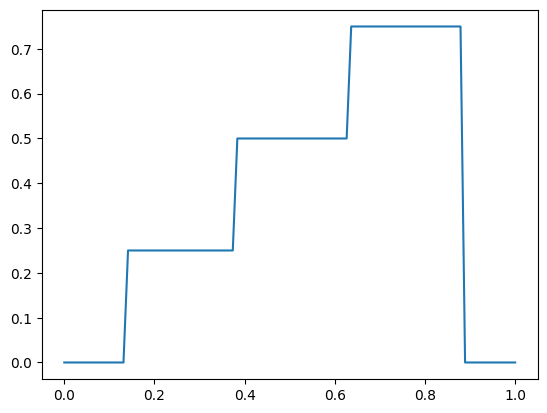

In [304]:
phiMeasures = []
for i in range(100):
    phi = np.pi * 2 * i / 100
    moreExactPhaseEstimation = f'''
3
INITSTATE BASIS |001>
H 0
H 1
CPHASE 2 1 {phi}
CPHASE 2 0 {phi}
CPHASE 2 0 {phi}
H 0
CPHASE 1 0 {-np.pi/2}
H 1
SWAP 0 1
MEASURE'''
    measures = S.ReadAndProcessString(Precompile(moreExactPhaseEstimation), measures=100)
    phiMeasures.append(max(set(measures), key = list(measures).count))
print(phiMeasures)
y = [int(m[:-1], 2)/4 for m in phiMeasures]
print(y)
x = np.linspace(0, 1, num = 100)
plt.plot(x, y)

Text(0.5, 1.0, '1000 measurements of phi = 0.1432394487827058')

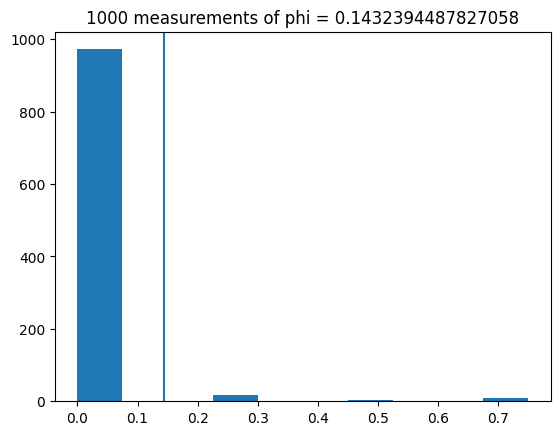

In [305]:
phi = 0.1432394487827058
moreExactPhaseEstimation = f'''
3
INITSTATE BASIS |001>
H 0
H 1
CPHASE 2 1 {phi}
CPHASE 2 0 {phi}
CPHASE 2 0 {phi}
H 0
CPHASE 1 0 {-np.pi/2}
H 1
SWAP 0 1
MEASURE'''
measures = S.ReadAndProcessString(Precompile(moreExactPhaseEstimation), measures=1000)
measures = [int(m[:-1], 2)/4 for m in measures]
fig, ax = plt.subplots(1)
ax.hist(measures, bins=10)
ax.axvline(0.1432394487827058)
ax.set_title(f"1000 measurements of phi = {phi}")


In [306]:
QFTtest = f'''
3
INITSTATE BASIS |100>
H 2
CPHASE 1 2 {np.pi/2}
CPHASE 0 2 {np.pi/4}
H 1
CPHASE 0 1 {np.pi/2}
H 0
REVERSE 0 2'''
PrettyPrintBinary(S.ReadAndProcessString(Precompile(QFTtest)))

0.3536+0.0000j |000> + 0.2500+0.2500j |001> + -0.3536+0.0000j |010> + -0.2500-0.2500j |011> + 0.0000+0.3536j |100> + -0.2500+0.2500j |101> + -0.0000-0.3536j |110> + 0.2500-0.2500j |111>


In [307]:
def GenerateQFT(nwires):
    out = ""
    for i in range(nwires-1, -1, -1):
        out += f"H {i}\n"
        for j in range(i):
            out += f"CPHASE {i} {i-j-1} {np.pi/(2**(j+1))}\n"
    out += f"REVERSE {0} {nwires-1}\n"
    return out
def invert(inString):
    a = inString.split("\n")
    a = a[::-1]
    out = ''
    for b in a:
        c = b.split(' ')
        if (c[0] == "P"):
            out += f"P {c[1]} {-float(c[2])}\n"
        else:
            out += f"{b}\n"
    return out
print(invert(Precompile(GenerateQFT(4))))



CNOT 0 2
CNOT 2 0
CNOT 0 2
H 0
P 1 -0.7853981633974483
CNOT 1 0
P 0 0.7853981633974483
CNOT 1 0
P 0 -0.7853981633974483
H 1
P 2 -0.39269908169872414
CNOT 2 0
P 0 0.39269908169872414
CNOT 2 0
P 0 -0.39269908169872414
P 2 -0.7853981633974483
CNOT 2 1
P 1 0.7853981633974483
CNOT 2 1
P 1 -0.7853981633974483
H 2
P 3 -0.19634954084936207
CNOT 3 0
P 0 0.19634954084936207
CNOT 3 0
P 0 -0.19634954084936207
P 3 -0.39269908169872414
CNOT 3 1
P 1 0.39269908169872414
CNOT 3 1
P 1 -0.39269908169872414
P 3 -0.7853981633974483
CNOT 3 2
P 2 0.7853981633974483
CNOT 3 2
P 2 -0.7853981633974483
H 3



In [308]:
def wrapper():
    input = '''
5
INITSTATE FILE myInputState.txt
'''
    input += Precompile(GenerateQFT(5))
    PrettyPrintBinary(S.ReadAndProcessString(input))
    print(input)
wrapper()

-0.0403-0.2209j |00000> + 0.0392+0.0239j |00001> + 0.0537-0.3213j |00010> + 0.0840-0.0938j |00011> + 0.1757+0.0802j |00100> + -0.0791+0.0339j |00101> + -0.1096+0.0022j |00110> + -0.1205-0.0218j |00111> + 0.0191+0.0706j |01000> + -0.0330+0.1764j |01001> + -0.0928-0.1661j |01010> + -0.0114+0.1021j |01011> + -0.0849-0.0967j |01100> + -0.1229-0.2535j |01101> + 0.1625-0.0853j |01110> + 0.2661-0.2084j |01111> + 0.2493+0.0642j |10000> + -0.1534+0.0395j |10001> + -0.1524-0.1436j |10010> + -0.1408+0.0677j |10011> + -0.0003+0.0288j |10100> + -0.0295-0.0398j |10101> + -0.0839+0.1516j |10110> + -0.0741-0.0497j |10111> + 0.0323-0.1069j |11000> + -0.0388-0.2765j |11001> + 0.0165-0.0136j |11010> + -0.0767+0.2151j |11011> + 0.0083-0.1441j |11100> + -0.0479+0.1906j |11101> + 0.0943-0.0559j |11110> + 0.0440+0.0910j |11111>

5
INITSTATE FILE myInputState.txt
H 4
P 3 0.7853981633974483
CNOT 4 3
P 3 -0.7853981633974483
CNOT 4 3
P 4 0.7853981633974483
P 2 0.39269908169872414
CNOT 4 2
P 2 -0.3926990816987241